In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from sklearn.metrics import precision_score, recall_score, f1_score

import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import os
from PIL import Image
import datetime

from typing import Any


In [2]:
root_dir = 'dataset/chest_xray/chest_xray/'
train_data_path = 'train'
test_data_path = 'test'
val_data_path = 'val'

In [3]:
train_transforms =  transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#test and validation
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
train_dataset = torchvision.datasets.ImageFolder(
    root=root_dir + train_data_path,
    transform=train_transforms
)
test_dataset = torchvision.datasets.ImageFolder(
    root=root_dir +test_data_path,
    transform=test_transforms
)
val_dataset = torchvision.datasets.ImageFolder(
    root=root_dir +val_data_path,
    transform=test_transforms
)
BATCH_SIZE = 64

In [5]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
print(len(train_loader.dataset))
print(len(test_loader.dataset))
print(len(val_loader.dataset))

classes = train_dataset.classes
print(classes)
print(train_dataset.class_to_idx)

5216
624
16
['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


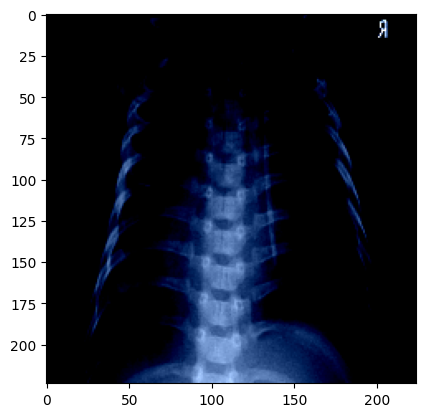

Label: 1


In [6]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().permute(1,2,0)
label = train_labels[1]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [7]:
class Network(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(3, 12, 3, stride=1, padding=1)
        # ((width - kernel_size + 2*padding)/stride) + 1
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        # shape now is 16, 12, 112, 112
        self.conv2 = nn.Conv2d(12, 16, 3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        #16, 16, 112, 112
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.relu3 = nn.ReLU()

        #hardcoded out_features but same as number of classes -> (NORMAL, PNEUMONIA) = 2
        self.fc1 = nn.Linear(32*112*112, out_features=784)
        self.fc2 = nn.Linear(784, 49)
        self.drop = nn.Dropout(0.3)
        self.fc3 = nn.Linear(49, 2)


    def forward(self, x):
        output = self.conv1(x)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        #fc -> we need to reshape it
        output = output.view(-1, 32*112*112)
        output = self.fc1(output)
        output = self.fc2(output)
        # dropout only for training !!!
        output = self.drop(output)
        output = self.fc3(output)
        return output

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
net = Network()
net.to(device)

cuda


Network(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc1): Linear(in_features=401408, out_features=784, bias=True)
  (fc2): Linear(in_features=784, out_features=49, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=49, out_features=2, bias=True)
)

In [8]:
class Network2(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=8)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=16)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=64)
        self.relu4 = nn.ReLU()
        self.fc1 = nn.Linear(64*28*28, out_features=128)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        # self.drop2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        output = self.conv1(x)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.pool(output)
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        output = self.pool(output)
        output = self.conv4(output)
        output = self.bn4(output)
        output = self.relu4(output)
        output = output.view(-1, 64*28*28)
        output = self.fc1(output)
        output = self.drop1(output)
        output = self.fc2(output)
        output = self.drop2(output)
        output = self.fc3(output)
        return output

net2 = Network2()
net2.to(device)

Network2(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

In [10]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [11]:
EPOCH = 10

def train(net, optimizer, criterion, train_loader, val_loader, epochs=10, device='cpu'):
    for epoch in range(epochs):  # loop over the dataset multiple times
        net.train()
        training_loss = 0.0
        valid_loss = 0.0
        all_labels = []
        all_predictions = []

        for _, data in enumerate(train_loader, 0):
            optimizer.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        writer.add_scalar('Loss/train', training_loss, epoch)

        net.eval()
        num_correct = 0
        num_examples = 0
        for _, data in enumerate(val_loader, 0):
            optimizer.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)

            loss = criterion(outputs, labels)
            valid_loss += loss.data.item() * inputs.size(0)
            predictions = torch.max(F.softmax(outputs, dim=1), dim=1)[1]
            correct = torch.eq(predictions, labels)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]

            all_labels.extend(labels.detach().cpu().numpy())
            all_predictions.extend(predictions.detach().cpu().numpy())

        valid_loss /= len(val_loader.dataset)
        writer.add_scalar('Loss/valid', valid_loss, epoch)
        writer.add_scalar('accuracy', num_correct / num_examples, epoch)

        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        writer.add_scalar('precision', precision, epoch)
        writer.add_scalar('recall', recall, epoch)
        writer.add_scalar('f1_score', f1, epoch)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}, precision = {:.2f}, recall = {:.2f}, f1_score = {:.2f}'.format(
            epoch, training_loss, valid_loss, num_correct / num_examples, precision, recall, f1))

    print('Finished Training')
    # writer.flush() # to make sure all is saved to disk

train(net, optimizer, criterion, train_loader, val_loader, EPOCH, device)

Epoch: 0, Training Loss: 4.59, Validation Loss: 0.93, accuracy = 0.88, precision = 0.90, recall = 0.88, f1_score = 0.87
Epoch: 1, Training Loss: 0.42, Validation Loss: 1.62, accuracy = 0.81, precision = 0.86, recall = 0.81, f1_score = 0.81
Epoch: 2, Training Loss: 0.39, Validation Loss: 0.14, accuracy = 0.94, precision = 0.94, recall = 0.94, f1_score = 0.94
Epoch: 3, Training Loss: 0.37, Validation Loss: 1.35, accuracy = 0.75, precision = 0.83, recall = 0.75, f1_score = 0.73
Epoch: 4, Training Loss: 0.31, Validation Loss: 1.31, accuracy = 0.88, precision = 0.90, recall = 0.88, f1_score = 0.87
Epoch: 5, Training Loss: 0.27, Validation Loss: 4.06, accuracy = 0.75, precision = 0.83, recall = 0.75, f1_score = 0.73
Epoch: 6, Training Loss: 0.35, Validation Loss: 4.26, accuracy = 0.69, precision = 0.81, recall = 0.69, f1_score = 0.65
Epoch: 7, Training Loss: 0.43, Validation Loss: 8.69, accuracy = 0.56, precision = 0.77, recall = 0.56, f1_score = 0.46
Epoch: 8, Training Loss: 0.54, Validatio

In [12]:
writer.close()

Testing the model

In [13]:
def test_model(net, test_loader, device="cpu"):
    net.eval()
    num_correct = 0
    num_examples = 0
    all_labels = []
    all_predictions = []

    for _, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        predictions = torch.max(F.softmax(outputs, dim=1), dim=1)[1]
        correct = torch.eq(predictions, labels)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]

        all_labels.extend(labels.detach().cpu().numpy())
        all_predictions.extend(predictions.detach().cpu().numpy())

    accuracy = num_correct / num_examples
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f"Testing Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}")
    return accuracy, precision, recall, f1

test_model(net, test_loader, device)

Testing Accuracy: 0.7435897435897436, Precision: 0.8137245485977718, Recall: 0.7435897435897436, F1-score: 0.6998418048008804


(0.7435897435897436,
 0.8137245485977718,
 0.7435897435897436,
 0.6998418048008804)

In [14]:
# torch.save(net, f'model_e{EPOCH}_{datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")}.pt')